# Snow Patches Monitoring - Data Visualization Demo

This notebook demonstrates:
1. **Interactive Map**: Visualization of Areas of Interest (AOIs) on a folium map
2. **Data Discovery**: Finding Sentinel-2 imagery for winter 2024/2025
3. **Image Visualization**: Downloading and displaying true-color satellite images

## Important Setup Notes

**Credentials Required**: This demo requires Copernicus Data Space credentials. Set the following environment variables:
- `SH_CLIENT_ID`
- `SH_CLIENT_SECRET`

Register for free at: https://dataspace.copernicus.eu/

**First Time Setup or After Code Updates**:
- If you just updated `notebook_utils.py` or other project files, restart the Jupyter kernel before running this notebook
- In Jupyter: Kernel → Restart Kernel
- This ensures you're using the latest version of the code

In [3]:
# Import required libraries
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append("..")

# Data handling
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Sentinel Hub
from sentinelhub import BBox, CRS

# Project modules
from data_handler.aoi import get_aois
from data_handler.discovery import create_sh_config, find_sentinel_products
from data_handler.notebook_utils import (
    create_aoi_map,
    get_winter_date_range,
    download_rgb_image,
    plot_sentinel_images
)

# Configure matplotlib for high-quality output
%matplotlib inline
plt.rcParams['figure.dpi'] = 150  # Increased from 100
plt.rcParams['savefig.dpi'] = 300  # For saving high-res images

## 1. Display Areas of Interest on Interactive Map

We monitor two regions in the Scottish Highlands:
- **Ben Nevis** (56.7969°N, 5.0036°W) - Highest peak in the British Isles
- **Ben Macdui** (57.0704°N, 3.6691°W) - Second highest peak in the British Isles

Each AOI covers a 10km × 10km area.

In [4]:
# Load AOI definitions
aois_gdf = get_aois()
print(f"Loaded {len(aois_gdf)} Areas of Interest:")
print(aois_gdf[['name', 'center_lat', 'center_lon', 'size_km']])

Loaded 2 Areas of Interest:
         name  center_lat  center_lon  size_km
0   Ben Nevis     56.7969     -5.0036     10.0
1  Ben Macdui     57.0704     -3.6691     10.0


In [5]:
# Create interactive map
aoi_map = create_aoi_map(aois_gdf)
aoi_map

## 2. Discover Sentinel-2 Products for Winter 2024/2025

We search for satellite imagery from **December 2024 through February 2025** with cloud cover ≤ 50%.

This winter period is critical for snow accumulation in the Scottish Highlands.

In [6]:
# Check credentials
if not os.getenv('SH_CLIENT_ID') or not os.getenv('SH_CLIENT_SECRET'):
    print("⚠️ WARNING: Sentinel Hub credentials not found!")
    print("Please set SH_CLIENT_ID and SH_CLIENT_SECRET environment variables.")
    print("Register at: https://dataspace.copernicus.eu/")
else:
    print("✓ Credentials found")

✓ Credentials found


In [7]:
# Configure Sentinel Hub
config = create_sh_config()

# DIAGNOSTIC: Verify config is pointing to Copernicus Data Space
print("Configuration check:")
print(f"  Base URL: {config.sh_base_url}")
print(f"  Token URL: {config.sh_token_url}")
print(f"  Expected base: https://sh.dataspace.copernicus.eu")
print(f"  Status: {'✓ CORRECT' if 'dataspace.copernicus.eu' in config.sh_base_url else '✗ WRONG - using commercial endpoint!'}")

# Define search parameters
winter_year = 2025
max_cloud_cover = 50.0  # 50% threshold

# Get winter date range
start_date, end_date = get_winter_date_range(winter_year)
print(f"\nWinter {winter_year-1}/{winter_year} period:")
print(f"  Start: {start_date.strftime('%Y-%m-%d')}")
print(f"  End:   {end_date.strftime('%Y-%m-%d')}")
print(f"  Cloud cover threshold: {max_cloud_cover}%")

Configuration check:
  Base URL: https://sh.dataspace.copernicus.eu
  Token URL: https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token
  Expected base: https://sh.dataspace.copernicus.eu
  Status: ✓ CORRECT

Winter 2024/2025 period:
  Start: 2024-12-01
  End:   2025-02-28
  Cloud cover threshold: 50.0%


In [8]:
# Discover products for each AOI
all_products = {}

for _, aoi in aois_gdf.iterrows():
    aoi_name = aoi['name']
    print(f"\nSearching for products over {aoi_name}...")
    
    # Find products
    products_df = find_sentinel_products(
        config=config,
        aoi_geometry=aoi['geometry'],
        start_date=start_date,
        end_date=end_date,
        max_cloud_cover=max_cloud_cover
    )
    
    all_products[aoi_name] = products_df
    
    print(f"  Found {len(products_df)} products")
    if len(products_df) > 0:
        print(f"  Cloud cover range: {products_df['cloud_cover'].min():.1f}% - {products_df['cloud_cover'].max():.1f}%")
        print(f"  Date range: {products_df['date'].min().strftime('%Y-%m-%d')} to {products_df['date'].max().strftime('%Y-%m-%d')}")


Searching for products over Ben Nevis...
  Found 14 products
  Cloud cover range: 5.3% - 49.3%
  Date range: 2024-12-10 to 2025-02-13

Searching for products over Ben Macdui...
  Found 13 products
  Cloud cover range: 14.6% - 49.3%
  Date range: 2024-12-05 to 2025-02-28


In [9]:
# Display products summary
for aoi_name, products_df in all_products.items():
    if len(products_df) > 0:
        print(f"\n{aoi_name} - Top 5 products (sorted by cloud cover):")
        print(
            products_df[['product_id', 'date', 'cloud_cover']]
            .sort_values('cloud_cover')
            .head(5)
            .to_string(index=False)
        )


Ben Nevis - Top 5 products (sorted by cloud cover):
                                                       product_id                             date  cloud_cover
S2A_MSIL2A_20250109T114441_N0511_R123_T30VUH_20250109T145751.SAFE 2025-01-09 11:45:37.229000+00:00         5.35
S2B_MSIL2A_20250213T114349_N0511_R123_T30VUJ_20250213T134729.SAFE 2025-02-13 11:45:31.441000+00:00         6.77
S2C_MSIL2A_20250208T114411_N0511_R123_T30VUJ_20250208T151210.SAFE 2025-02-08 11:45:53.866000+00:00        11.81
S2A_MSIL2A_20250119T114411_N0511_R123_T30VUJ_20250119T145457.SAFE 2025-01-19 11:45:26.196000+00:00        24.09
S2A_MSIL2A_20250106T113451_N0511_R080_T30VUH_20250106T154249.SAFE 2025-01-06 11:35:41.226000+00:00        25.65

Ben Macdui - Top 5 products (sorted by cloud cover):
                                                       product_id                             date  cloud_cover
S2A_MSIL2A_20241210T114501_N0511_R123_T30VVJ_20241210T145652.SAFE 2024-12-10 11:45:22.995000+00:00        14.

## 3. Download and Visualize Satellite Images

We'll download true-color RGB images (Red, Green, Blue bands) for the products with the lowest cloud cover.

**Note**: This step requires active internet connection and may take a few minutes depending on the number of products.

In [10]:
# Configure download parameters
max_images_per_aoi = 9  # Download up to 9 images per AOI (3x3 grid)
resolution = 20  # Use 20m resolution for faster downloads

print(f"Download settings:")
print(f"  Maximum images per AOI: {max_images_per_aoi}")
print(f"  Resolution: {resolution}m")
print(f"  AOIs to process: {', '.join(all_products.keys())}")

Download settings:
  Maximum images per AOI: 9
  Resolution: 20m
  AOIs to process: Ben Nevis, Ben Macdui


In [11]:
# Download RGB images for all AOIs
all_images = {}  # Dictionary to store images for each AOI

for aoi_name, products_df in all_products.items():
    print(f"\n{'='*80}")
    print(f"Processing AOI: {aoi_name}")
    print(f"{'='*80}")
    
    if len(products_df) == 0:
        print(f"  No products found for {aoi_name}")
        all_images[aoi_name] = {'images': [], 'bbox': None}
        continue
    
    # Get AOI geometry for creating bbox
    aoi_row = aois_gdf[aois_gdf['name'] == aoi_name].iloc[0]
    
    # Create bbox (use smaller area to avoid resolution limits)
    center_lon = aoi_row['center_lon']
    center_lat = aoi_row['center_lat']
    bbox = BBox(
        bbox=[center_lon - 0.05, center_lat - 0.05, center_lon + 0.05, center_lat + 0.05],
        crs=CRS.WGS84
    )
    
    print(f"  Bounding box: [{bbox.min_x:.3f}°, {bbox.min_y:.3f}°] to [{bbox.max_x:.3f}°, {bbox.max_y:.3f}°]")
    
    # Sort products by cloud cover and select top N
    products_to_download = products_df.sort_values('cloud_cover').head(max_images_per_aoi)
    
    # Download RGB images
    images_data = []
    
    for idx, (_, product) in enumerate(products_to_download.iterrows(), 1):
        print(f"  [{idx}/{len(products_to_download)}] {product['date'].strftime('%Y-%m-%d')} (Cloud: {product['cloud_cover']:.1f}%)...", end=' ')
        
        try:
            rgb_image = download_rgb_image(
                config=config,
                bbox=bbox,
                date=product['date'],
                product_id=product['product_id'],
                resolution=resolution
            )
            
            images_data.append({
                'image': rgb_image,
                'date': product['date'],
                'cloud_cover': product['cloud_cover']
            })
            
            print(f"✓ ({rgb_image.shape[0]} × {rgb_image.shape[1]} px)")
            
        except Exception as e:
            print(f"✗ Failed: {str(e)[:60]}...")
    
    # Store results
    all_images[aoi_name] = {
        'images': images_data,
        'bbox': bbox
    }
    
    print(f"\n  Summary: Downloaded {len(images_data)}/{len(products_to_download)} images for {aoi_name}")

print(f"\n{'='*80}")
print(f"Download Complete")
print(f"{'='*80}")
for aoi_name, data in all_images.items():
    print(f"  {aoi_name}: {len(data['images'])} images")


Processing AOI: Ben Nevis
  Bounding box: [-5.054°, 56.747°] to [-4.954°, 56.847°]
  [1/9] 2025-01-09 (Cloud: 5.3%)... ✓ (555 × 310 px)
  [2/9] 2025-02-13 (Cloud: 6.8%)... ✓ (555 × 310 px)
  [3/9] 2025-02-08 (Cloud: 11.8%)... ✓ (555 × 310 px)
  [4/9] 2025-01-19 (Cloud: 24.1%)... ✓ (555 × 310 px)
  [5/9] 2025-01-06 (Cloud: 25.6%)... ✓ (555 × 310 px)
  [6/9] 2025-02-08 (Cloud: 33.0%)... ✓ (555 × 310 px)
  [7/9] 2025-01-09 (Cloud: 34.2%)... ✓ (555 × 310 px)
  [8/9] 2025-01-29 (Cloud: 38.3%)... ✓ (555 × 310 px)
  [9/9] 2024-12-10 (Cloud: 40.6%)... ✓ (555 × 310 px)

  Summary: Downloaded 9/9 images for Ben Nevis

Processing AOI: Ben Macdui
  Bounding box: [-3.719°, 57.020°] to [-3.619°, 57.120°]
  [1/9] 2024-12-10 (Cloud: 14.6%)... ✓ (555 × 310 px)
  [2/9] 2025-01-04 (Cloud: 16.1%)... ✓ (555 × 310 px)
  [3/9] 2024-12-10 (Cloud: 16.2%)... ✓ (555 × 310 px)
  [4/9] 2025-01-19 (Cloud: 19.2%)... ✓ (555 × 310 px)
  [5/9] 2025-01-21 (Cloud: 24.4%)... ✓ (555 × 310 px)
  [6/9] 2025-02-05 (Cloud: 25


Plotting 9 images for Ben Nevis...


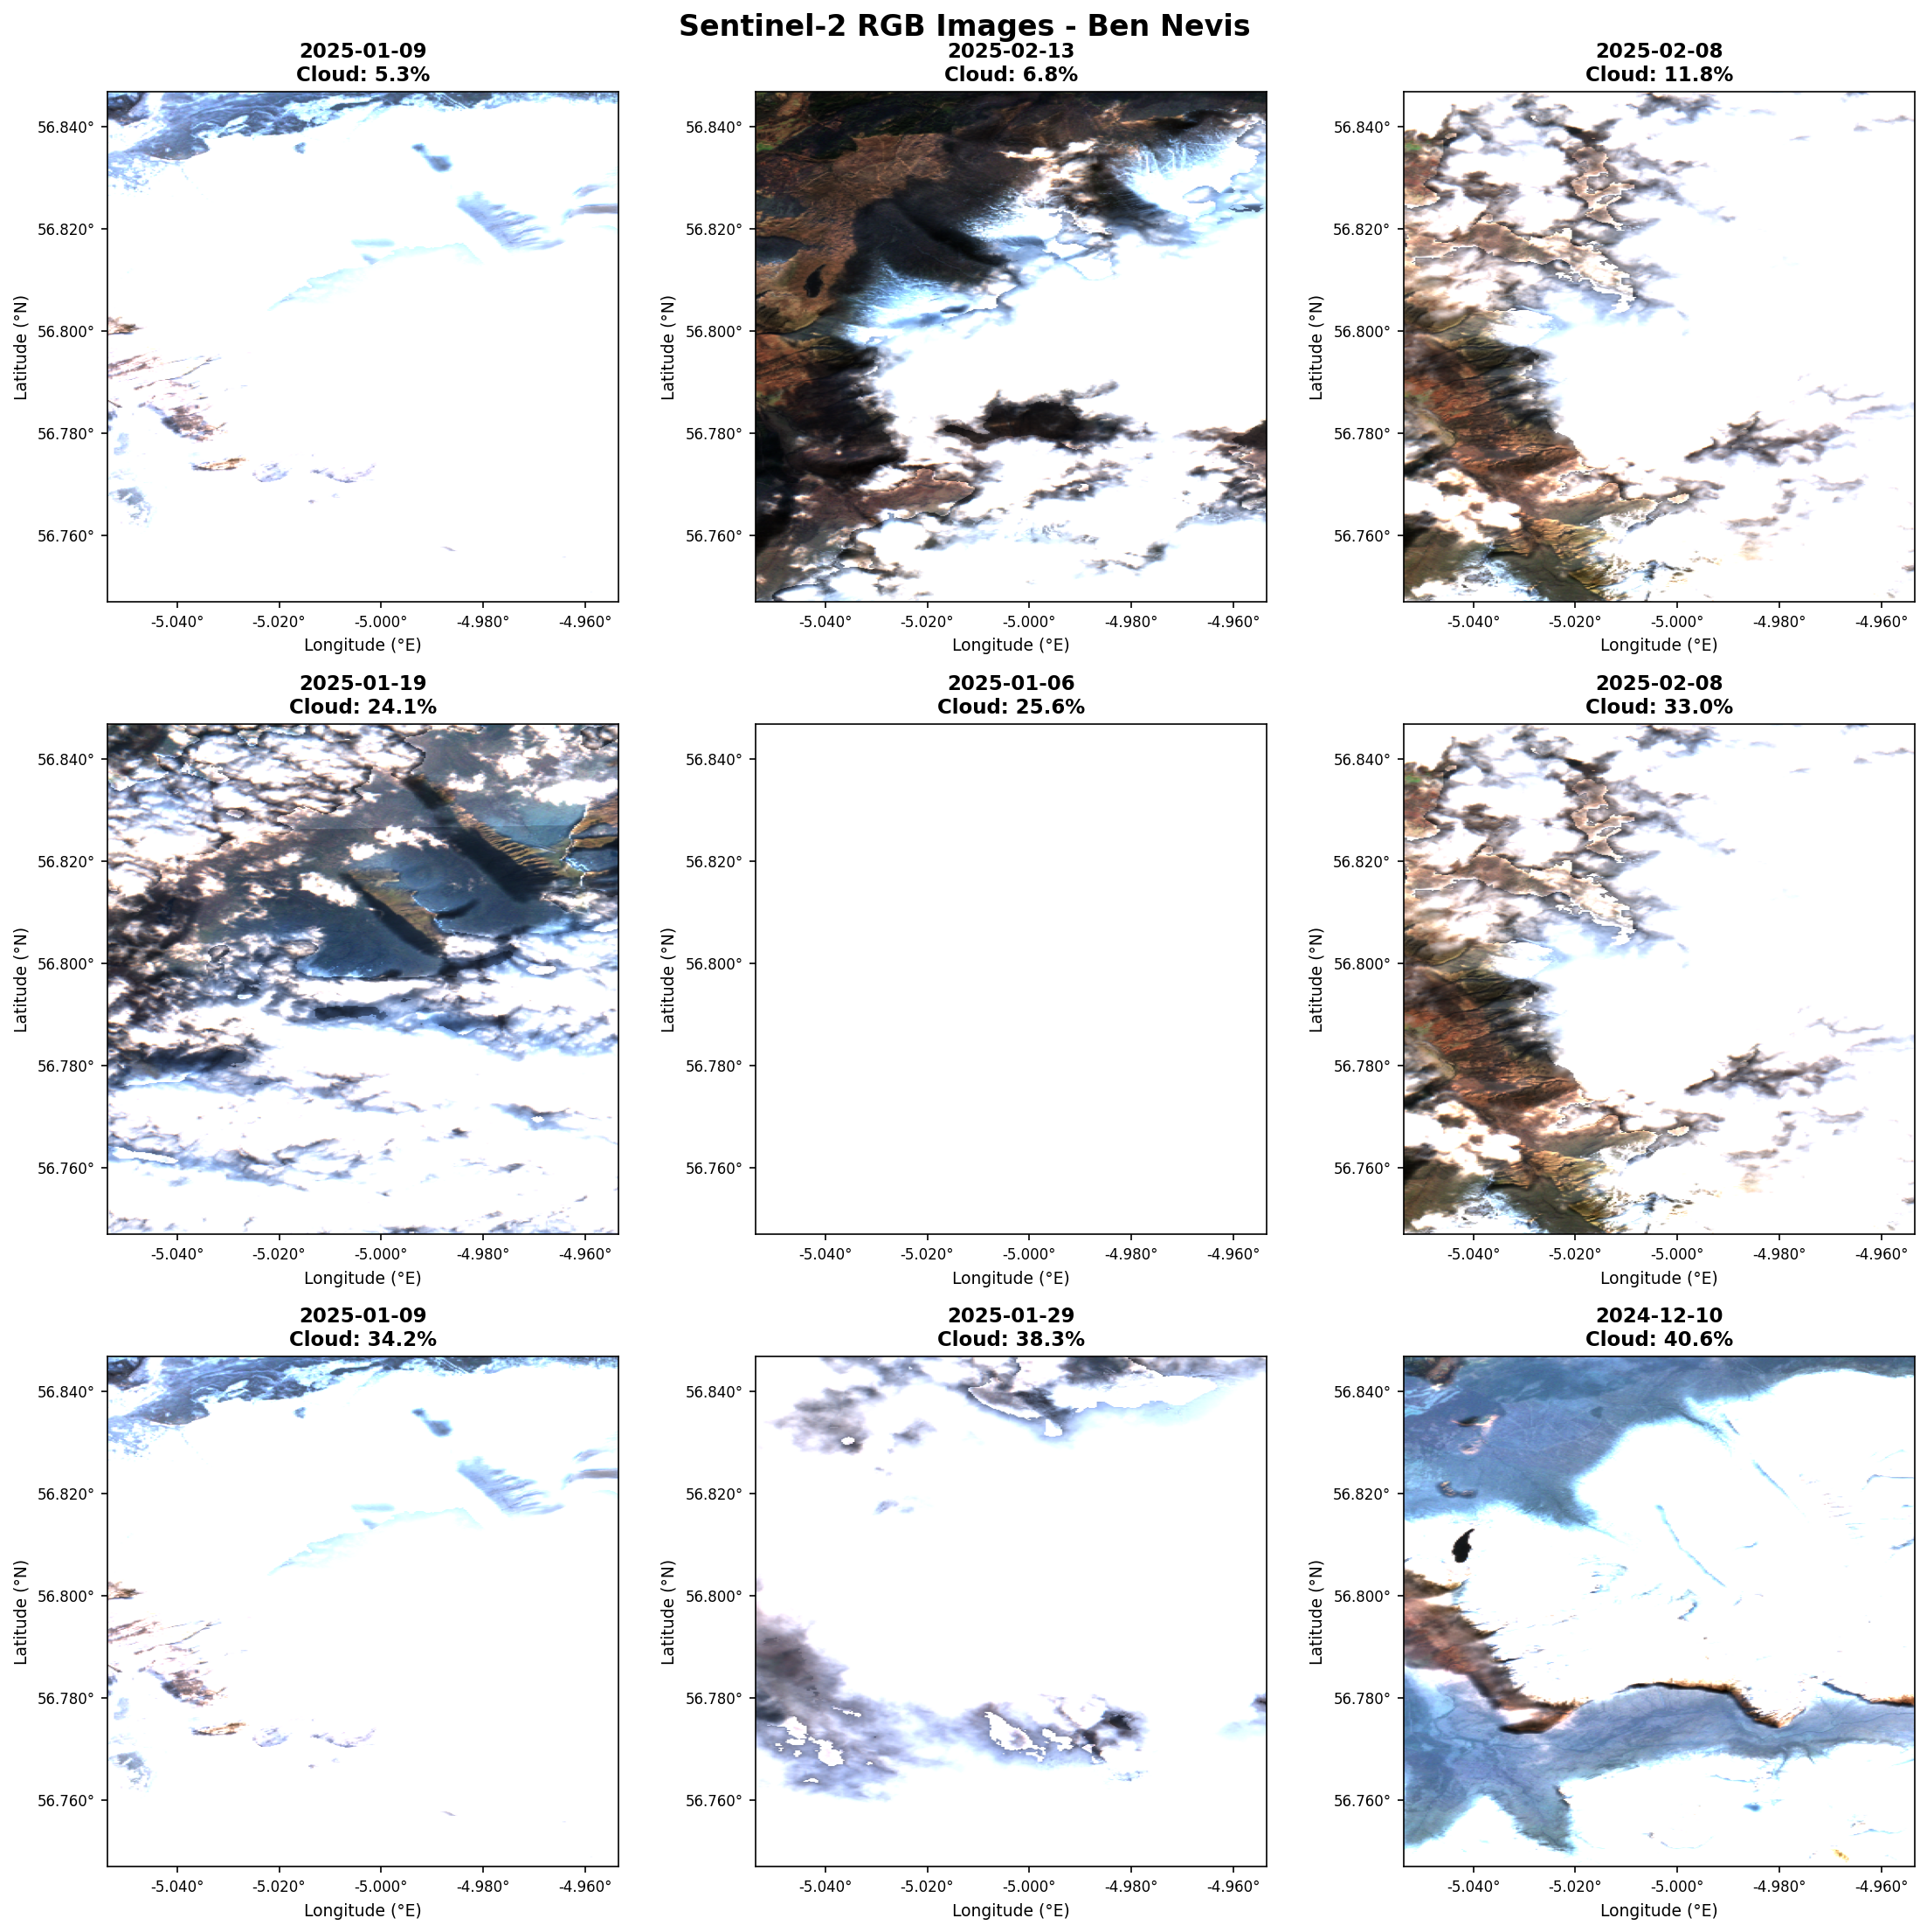

Displayed 9 images for Ben Nevis

Plotting 9 images for Ben Macdui...


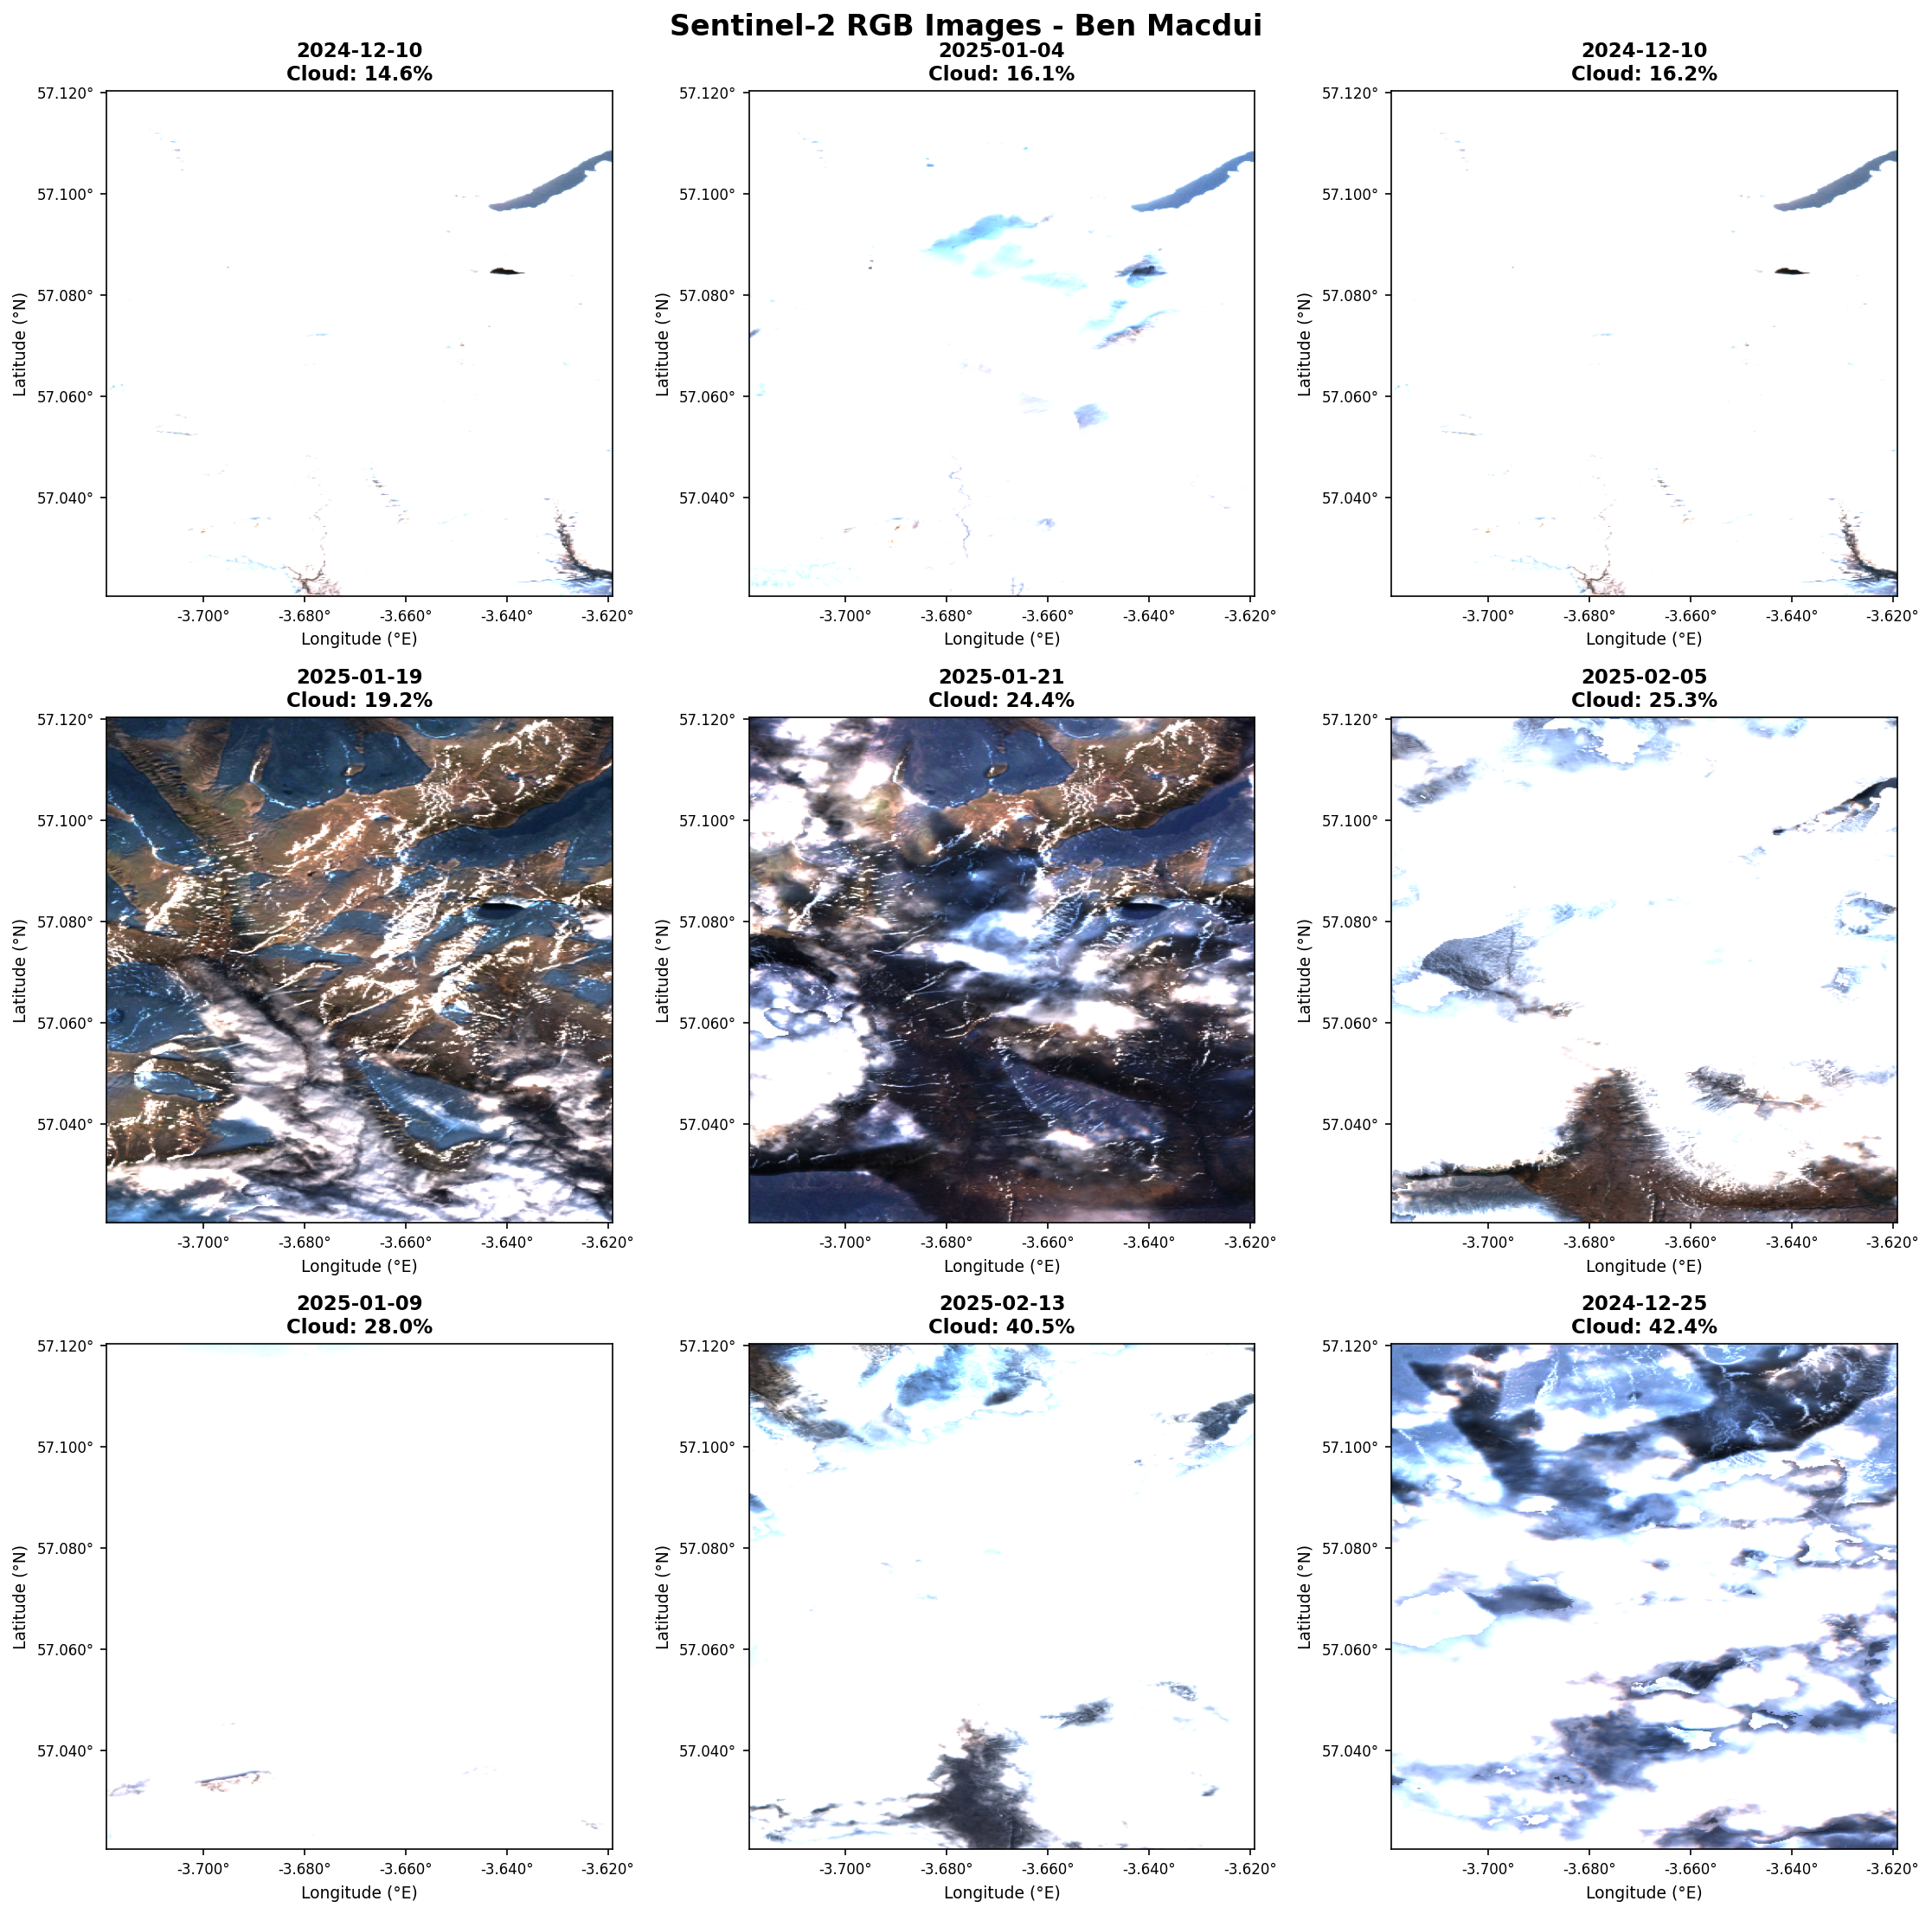

Displayed 9 images for Ben Macdui


In [12]:
# Plot the downloaded images for each AOI
for aoi_name, data in all_images.items():
    images_data = data['images']
    bbox = data['bbox']
    
    if len(images_data) == 0:
        print(f"\nNo images to display for {aoi_name}")
        continue
    
    print(f"\nPlotting {len(images_data)} images for {aoi_name}...")
    
    # Create visualization with lat/lon coordinates
    fig = plot_sentinel_images(
        images=images_data,
        aoi_name=aoi_name,
        bbox=bbox,
        ncols=3,  # 3 columns for nice grid layout
        brightness_factor=3.5,  # Enhance visibility
        dpi=150  # High quality
    )
    
    plt.show()
    print(f"Displayed {len(images_data)} images for {aoi_name}")

## Summary

This notebook demonstrated:
- ✓ Visualizing AOIs on an interactive folium map
- ✓ Discovering Sentinel-2 products for winter 2024/2025
- ✓ Downloading and displaying true-color satellite imagery

**Next Steps**:
- Apply snow detection algorithms (NDSI threshold)
- Track snow cover changes over time
- Generate time-series plots of snow coverage

---

*Generated with snow-patches monitoring pipeline*